# Pitstop Arabia
Pitstop arabia is an online tyre ordering service. You order the tyre online, they purchase it and direct you to one of their locations for it to be installed. I have aquiered data pertaining to the sales of the tyres themselves and the installer locations.

The goal of this project is to predict how many tyres a location may need, as well as what brand or type of tyre.

Let's start by importing our standard libraries: 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

And read in the data: 

In [3]:
tyres = pd.read_csv("tire_data/tyre_data_analysis.csv")

print("Size of the data set: ", tyres.shape)
print("What information we have on 1 purchase: \n", tyres.columns)

Size of the data set:  (2574, 24)
What information we have on 1 purchase: 
 Index(['Order Date', 'Order #', 'Order Status', 'Service Date',
       'Installer Name', 'Installer Address', 'Installer City', 'Vehicle Reg',
       'Vehicle Make', 'Vehicle Model', 'Vehicle Year ', 'SKU', 'Brand',
       'Name', 'QTY Ordered', 'width', 'height', 'rim size', 'year',
       'Subtotal ', 'Shipping & Handling ', 'Discount', 'Tax Amount',
       'Grand Total'],
      dtype='object')


In [4]:
tyres.head(6)

,Order Date,Order #,Order Status,Service Date,Installer Name,Installer Address,Installer City,Vehicle Reg,Vehicle Make,Vehicle Model,...,QTY Ordered,width,height,rim size,year,Subtotal,Shipping & Handling,Discount,Tax Amount,Grand Total
0,2/1/2016 13:01,100000225.0,complete,4/1/2016,ZDegree,"Hessa - ENOC Petrol Station, Al Khail Rd, \r\n...",Dubai,R19508,bmw,3-series,...,4,225,45,18,2020.0,3588.0,0.0,0.0,0.0,3588.0
1,4/1/2016 16:15,100000230.0,complete,6/1/2016,TyrePlus,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,D34841,toyota,fj-cruiser,...,4,275,70,16,2019.0,2396.0,0.0,0.0,0.0,2396.0
2,4/1/2016 18:17,100000231.0,complete,6/1/2016,TyrePlus,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,67790,mercedes,c-class-amg,...,2,NaN,NaN,NaN,NaN,998.0,0.0,0.0,0.0,998.0
3,5/1/2016 10:21,100000233.0,complete,8/1/2016,ZDegree,"Shk Mohd Bin Zd Rd, E 311, -Inside Enoc Fuel S...",Dubai,82794,Honda,MRV,...,2,NaN,NaN,NaN,NaN,870.0,0.0,0.0,0.0,870.0
4,7/1/2016 17:22,100000235.0,complete,16-01-16,TyrePlus,"behind Honda Showroom / Oasis Centre , Opposit...",Dubai,44557k,mercedes,e-class,...,2,255,35,18,2020.0,3752.0,0.0,0.0,0.0,3752.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,235,40,18,2019.0,NaN,NaN,NaN,NaN,NaN


# Dropping Unecessary Columns
Time series analysis needs only 2 compoennts, time and the qunaitity to predict. I also plan to use lcoation to split this data into chunks, so keeping the address is a must. everything else is unecessary for this problem:


In [5]:
tyres.columns

Index(['Order Date', 'Order #', 'Order Status', 'Service Date',
       'Installer Name', 'Installer Address', 'Installer City', 'Vehicle Reg',
       'Vehicle Make', 'Vehicle Model', 'Vehicle Year ', 'SKU', 'Brand',
       'Name', 'QTY Ordered', 'width', 'height', 'rim size', 'year',
       'Subtotal ', 'Shipping & Handling ', 'Discount', 'Tax Amount',
       'Grand Total'],
      dtype='object')

In [6]:
drop_columns = ['Installer Name',
                'Vehicle Reg',
                'Vehicle Make',
                'Vehicle Model',
                'Vehicle Year ',
                'SKU',
                'Brand',
                'Name',
                'width',
                'height',
                'rim size',
                'year',
                'Shipping & Handling ',
                'Discount',
                'Tax Amount']
tyres.drop(drop_columns, axis = 1, inplace = True)

In [9]:
tyres

,Order Date,Order #,Order Status,Service Date,Installer Address,Installer City,QTY Ordered,Subtotal,Grand Total
0,2/1/2016 13:01,100000225.0,complete,4/1/2016,"Hessa - ENOC Petrol Station, Al Khail Rd, \r\n...",Dubai,4,3588.0,3588.0
1,4/1/2016 16:15,100000230.0,complete,6/1/2016,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,4,2396.0,2396.0
2,4/1/2016 18:17,100000231.0,complete,6/1/2016,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,2,998.0,998.0
3,5/1/2016 10:21,100000233.0,complete,8/1/2016,"Shk Mohd Bin Zd Rd, E 311, -Inside Enoc Fuel S...",Dubai,2,870.0,870.0
4,7/1/2016 17:22,100000235.0,complete,16-01-16,"behind Honda Showroom / Oasis Centre , Opposit...",Dubai,2,3752.0,3752.0
...,...,...,...,...,...,...,...,...,...
2569,30-08-17 10:34,158145337.0,complete,31-08-17,Khalifa city,Abu Dhabi,4,1196.0,1196.0
2570,30-08-17 11:48,100000252.0,complete,30-08-17,"off Sheikh Zayed Road, Al Quoz service Road, O...",Dubai,4,1520.0,1140.0
2571,30-08-17 14:42,151276661.0,complete,31-08-17,"10th St corner Baghdad St, Grand Service Stati...",Dubai,4,1676.0,1676.0
2572,30-08-17 15:27,102595419.0,complete,31-08-17,Behind Home Center Warehouse,Dubai,4,1528.0,1528.0


# Fixing 2nd tyre order issue

Sometimes, a customer has differnet tyres in the back and front, and when that happens a new row is added and the information about the second tire is added to the next row. I would hate to throw this data away, so I will try and make some new features to accomadate these anomolies. Let's take a look at an example, say row 5: 

In [17]:
tyres.iloc[5,:]

Order Date           NaN
Order #              NaN
Order Status         NaN
Service Date         NaN
Installer Address    NaN
Installer City       NaN
QTY Ordered            2
Subtotal             NaN
Grand Total          NaN
Name: 5, dtype: object

It would be a shame to simply throw this data away. Since the customer is the same, we can simply take the rest of the info from the previous row and add it to the null row. It is part of the same order as the previous, so the same order number will be used.

In [18]:
null_index = tyres[tyres['Order #'].isna() == True].index
t_columns = ['Order Date', 'Order #', 'Order Status', 'Service Date',
       'Installer Address', 'Installer City', 'Subtotal ',
       'Grand Total']


for i in null_index: #For every null row
    for col in t_columns: #for every column
        tyres.loc[i,col] = tyres.loc[i-1,col] #make the previous order info the same, except for the QTY ordered

In [20]:
tyres.head(6)

,Order Date,Order #,Order Status,Service Date,Installer Address,Installer City,QTY Ordered,Subtotal,Grand Total
0,2/1/2016 13:01,100000225.0,complete,4/1/2016,"Hessa - ENOC Petrol Station, Al Khail Rd, \r\n...",Dubai,4,3588.0,3588.0
1,4/1/2016 16:15,100000230.0,complete,6/1/2016,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,4,2396.0,2396.0
2,4/1/2016 18:17,100000231.0,complete,6/1/2016,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,2,998.0,998.0
3,5/1/2016 10:21,100000233.0,complete,8/1/2016,"Shk Mohd Bin Zd Rd, E 311, -Inside Enoc Fuel S...",Dubai,2,870.0,870.0
4,7/1/2016 17:22,100000235.0,complete,16-01-16,"behind Honda Showroom / Oasis Centre , Opposit...",Dubai,2,3752.0,3752.0
5,7/1/2016 17:22,100000235.0,complete,16-01-16,"behind Honda Showroom / Oasis Centre , Opposit...",Dubai,2,3752.0,3752.0
6,9/1/2016 10:55,100000236.0,complete,11/1/2016,Dubai,Dubai,4,2596.0,2695.0
7,10/1/2016 11:17,100000238.0,complete,12/1/2016,"Shk Mohd Bin Zd Rd, E 311, -Inside Enoc Fuel S...",Dubai,4,3356.0,3356.0


Excellent! We retained the data. Now let's work on converting it to the data types we need. 

## Converting to correct data types
Some columns don't have the correct type, which is a problem for our modeling. I also want to make sure that most (if not all) rows are binary, which further helps with modeling. Let's see what they are currently: 

In [22]:
tyres.dtypes

Order Date            object
Order #              float64
Order Status          object
Service Date          object
Installer Address     object
Installer City        object
QTY Ordered            int64
Subtotal             float64
Grand Total          float64
dtype: object

Let's solve this problem row by row, we'll begin with the order date: 

In [86]:
tyres.loc[:,"Order Date"] = pd.to_datetime(tyres.loc[:,"Order Date"]) #Order Date (date time)

tyres.loc[:,"Service Date"] = pd.to_datetime(tyres.loc[:,"Service Date"]) #Service Date (date time)

#They were also out of order, so I sort them here: 
tyres.sort_values(by = ['Order Date']);

tyres = tyres[tyres['QTY Ordered'] < 30]

Now for the order status. 

A quick peruse reveals that processing, psa_review and canceled_payfortcw can be dropped

In [25]:
tyres['Order Status'].unique()

array(['complete', 'closed', 'canceled_payfortcw', 'psa_review',
       'processing'], dtype=object)

In [26]:
status_to_drop = ['canceled_payfortcw','psa_review','processing'] #Negligable status

for status in status_to_drop:
    tyres = tyres[tyres['Order Status'] != status] #Drop any rows that have these statuses

tyres.reset_index(inplace = True)
tyres.drop(["index"], axis = 1, inplace = True) #Reset the index

## Locations
Now for the addresses, one of the most important parts. What I am predicting, is what amount of tires would be needed in what locations on what day. However, there is sever class imblance in terms of location usage. Below is the plotted usage of each of the locations: 

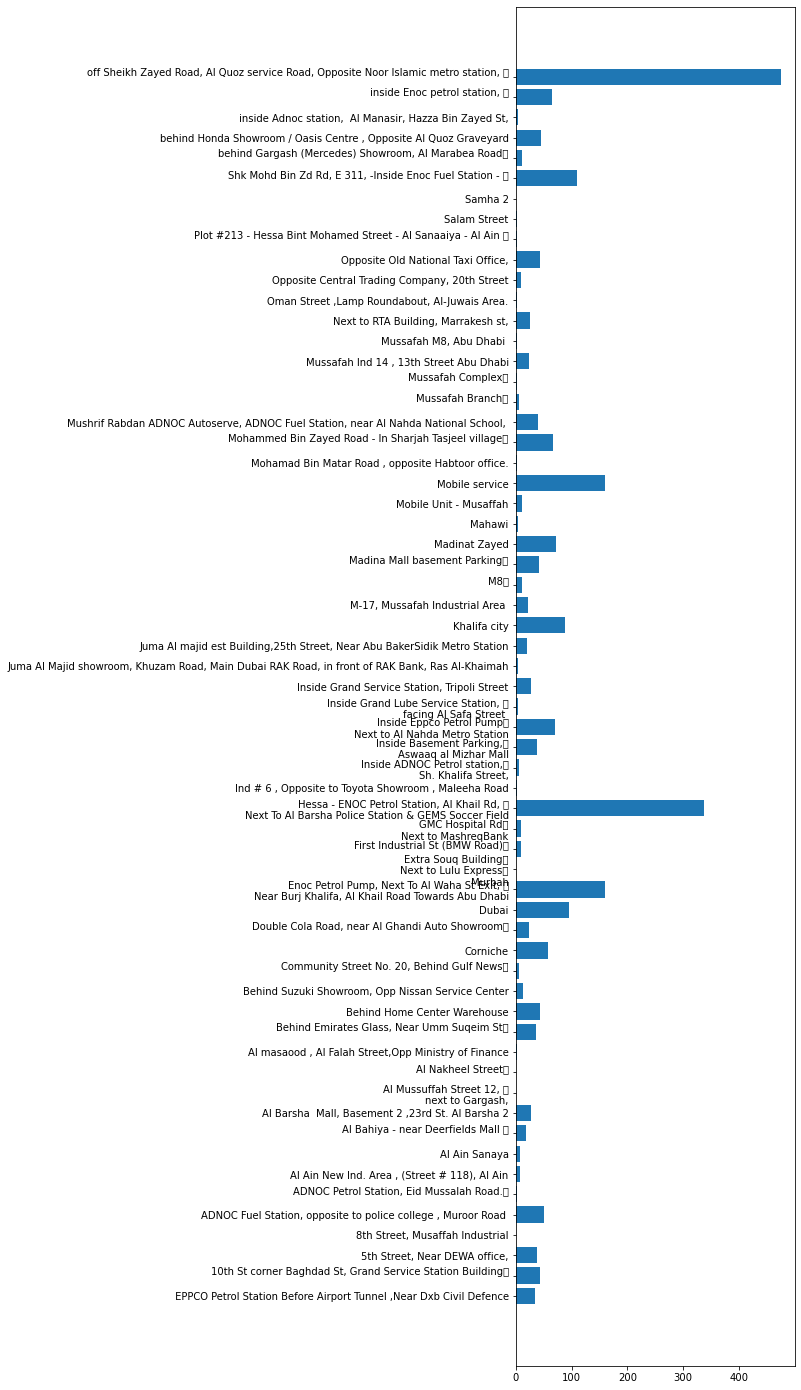

In [31]:
grouped_locations = tyres.groupby("Installer Address")["QTY Ordered"].count() #Group counts
grouped_locations = pd.DataFrame(grouped_locations) #Convert to DF
grouped_locations.reset_index(inplace = True) #Reset the index

#Ready for plotting!

plt.figure(figsize = (5,25))
plt.barh(grouped_locations['Installer Address'], grouped_locations['QTY Ordered'])
plt.show()

A much simpler approach would be group these locations together for plotting. We will need both the latitude and longitude of each location in order to make appropriate bounds.

Normally, I would use the google API to exchange the adress for the coordinates, however Dubai (and the middle east in general) has a problem with formal addressess, they don't really have any.

During my time in Saudi Arabia, there were addressess, but many were not formally recorded (*more of a decoration than anything else*). 
It wasn't until [2010](https://www.esri.com/news/arcnews/winter1011articles/saudi-arabia.html#:~:text=Traditionally%2C%20home%20and%20street%20addresses,directly%20from%20the%20post%20office.) in Saudi Arabia and [2015](https://www.citymetric.com/horizons/buildings-dubai-and-abu-dhabi-didnt-have-official-addresses-thats-finally-changing-838) in the United Arab Emirates that postal codes and the like started to become used more often. It still isn't the most robust system, and many rely on landmaks like "the Emirates Mall" or "the gas station next to the Burj Khalifa" for addressess. 

This lead to the (painfully) manual process of going through google maps for all 61 unique locations. Please enjoy my work below: 

In [32]:
tyres['Installer Address'].fillna(method = 'ffill', inplace = True)
len(tyres['Installer Address'].unique())
tyres

,Order Date,Order #,Order Status,Service Date,Installer Address,Installer City,QTY Ordered,Subtotal,Grand Total
0,2016-02-01 13:01:00,100000225.0,complete,2016-04-01,"Hessa - ENOC Petrol Station, Al Khail Rd, \r\n...",Dubai,4,3588.0,3588.0
1,2016-04-01 16:15:00,100000230.0,complete,2016-06-01,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,4,2396.0,2396.0
2,2016-04-01 18:17:00,100000231.0,complete,2016-06-01,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,2,998.0,998.0
3,2016-05-01 10:21:00,100000233.0,complete,2016-08-01,"Shk Mohd Bin Zd Rd, E 311, -Inside Enoc Fuel S...",Dubai,2,870.0,870.0
4,2016-07-01 17:22:00,100000235.0,complete,2016-01-16,"behind Honda Showroom / Oasis Centre , Opposit...",Dubai,2,3752.0,3752.0
...,...,...,...,...,...,...,...,...,...
2560,2017-08-30 10:34:00,158145337.0,complete,2017-08-31,Khalifa city,Abu Dhabi,4,1196.0,1196.0
2561,2017-08-30 11:48:00,100000252.0,complete,2017-08-30,"off Sheikh Zayed Road, Al Quoz service Road, O...",Dubai,4,1520.0,1140.0
2562,2017-08-30 14:42:00,151276661.0,complete,2017-08-31,"10th St corner Baghdad St, Grand Service Stati...",Dubai,4,1676.0,1676.0
2563,2017-08-30 15:27:00,102595419.0,complete,2017-08-31,Behind Home Center Warehouse,Dubai,4,1528.0,1528.0


In [33]:
add_coo = {} #Dictionary associating each location with their respective lattitude and longitude
add_coo['Hessa - ENOC Petrol Station, Al Khail Rd, \r\nNext To Al Barsha Police Station & GEMS Soccer Field'] = (25.066277, 55.218215)
add_coo[' \r\nNext To Al Barsha Police Station & GEMS Soccer Field'] = (25.080584, 55.215431)
add_coo['Al Barsha  Mall, Basement 2 ,23rd St. Al Barsha 2'] = (25.098187, 55.203553)
add_coo['Shk Mohd Bin Zd Rd, E 311, -Inside Enoc Fuel Station - \r\n'] = (25.059133, 55.285133)
add_coo['behind Honda Showroom / Oasis Centre , Opposite Al Quoz Graveyard'] = (25.168575, 55.241198)
add_coo['Dubai'] = (25.152925, 55.262578)
add_coo['inside Enoc petrol station, \r\n'] = (25.150143, 55.244540)
add_coo['10th St corner Baghdad St, Grand Service Station Building\r\n'] = (25.199583, 55.441530)
add_coo['Behind Suzuki Showroom, Opp Nissan Service Center'] = (25.259433, 55.334238)
add_coo['Next to RTA Building, Marrakesh st,'] = (25.233531, 55.356299)
add_coo['Inside Grand Service Station, Tripoli Street'] = (25.199680, 55.441432)
add_coo['M-17, Mussafah Industrial Area '] = (24.364980, 54.491010)
add_coo['Enoc Petrol Pump, Next To Al Waha St Exit, \r\nNear Burj Khalifa, Al Khail Road Towards Abu Dhabi'] = (25.211362, 55.259310)
add_coo['Khalifa city'] = (24.405996, 54.602742)
add_coo['Corniche'] = (25.256534, 55.306121)
add_coo['Behind Emirates Glass, Near Umm Suqeim St\r\n'] = (25.114569, 55.222304)
add_coo['Al masaood , Al Falah Street,Opp Ministry of Finance'] = (24.485140, 54.378802)
add_coo['Salam Street'] = (24.413092, 54.503905)
add_coo['Opposite Central Trading Company, 20th Street'] = (25.129721, 55.245257)
add_coo['Plot #213 - Hessa Bint Mohamed Street - Al Sanaaiya - Al Ain \r\n'] = (24.213164, 55.760262)
add_coo['Inside Grand Lube Service Station, \r\nfacing Al Safa Street '] = (25.207087, 55.268465)
add_coo['behind Gargash (Mercedes) Showroom, Al Marabea Road\r\n'] = (25.130630, 55.219551)
add_coo['Mobile Unit - Musaffah'] = (24.346592, 54.487272)
add_coo['Juma Al majid est Building,25th Street, Near Abu BakerSidik Metro Station'] = (25.270249, 55.326704)
add_coo[' EPPCO Petrol Station Before Airport Tunnel ,Near Dxb Civil Defence'] = (25.267141, 55.355484)
add_coo['Inside ADNOC Petrol station,\r\nSh. Khalifa Street,'] = (24.499881, 54.368962)
add_coo['First Industrial St (BMW Road)\r\n'] = (25.320569, 55.401860)
add_coo['Madinat Zayed'] = (23.666361, 53.695055)
add_coo['ADNOC Fuel Station, opposite to police college , Muroor Road '] = (24.436862, 54.422066)
add_coo['Opposite Old National Taxi Office,'] = (25.115186, 55.220820)
add_coo['Samha 2'] = (24.671022, 54.759717)
add_coo['M8\r\n'] = (25.286304, 55.478272)
add_coo['Mohamad Bin Matar Road , opposite Habtoor office.'] = (25.166264, 55.225182)
add_coo['Mahawi'] = (24.349637, 54.584522)
add_coo['Mussafah Branch\r\n'] = (24.377345, 54.497503)
add_coo['Double Cola Road, near Al Ghandi Auto Showroom\r\n'] = (25.332196, 55.470854)
add_coo['Inside Eppco Petrol Pump\r\nNext to Al Nahda Metro Station'] = (25.274270, 55.368493)
add_coo['off Sheikh Zayed Road, Al Quoz service Road, Opposite Noor Islamic metro station, \r\n'] = (25.154543, 55.228176)
add_coo['Mobile service'] = (24.5, 54.3) #####981234798012374089271940892314
add_coo['Juma Al Majid showroom, Khuzam Road, Main Dubai RAK Road, in front of RAK Bank, Ras Al-Khaimah'] = (25.707212, 55.970226)
add_coo['Mohammed Bin Zayed Road - In Sharjah Tasjeel village\r\n'] = (25.343653, 55.473574)
add_coo['Madina Mall basement Parking\r\n'] = (25.281752, 55.398280)
add_coo['Inside Basement Parking,\r\nAswaaq al Mizhar Mall'] = (25.246192, 55.452685)
add_coo['Al Mussuffah Street 12, \r\nnext to Gargash,'] = (24.360125, 54.504070)
add_coo['Mussafah Ind 14 , 13th Street Abu Dhabi'] = (24.330692, 54.533828)
add_coo['Al Ain Sanaya'] = (24.179849, 55.762638)
add_coo['Oman Street ,Lamp Roundabout, Al-Juwais Area.'] = (25.769444, 55.974937)
add_coo['Al Ain New Ind. Area , (Street # 118), Al Ain'] = (24.220467, 55.758508)
add_coo['ADNOC Petrol Station, Eid Mussalah Road.\r\n'] = (24.239734, 55.696923)
add_coo['Behind Home Center Warehouse'] = (25.144578, 55.230620)
add_coo['GMC Hospital Rd\r\nNext to MashreqBank'] = (25.382247, 55.462849)
add_coo['Community Street No. 20, Behind Gulf News\r\n'] = (25.258551, 55.321747)
add_coo['Mushrif Rabdan ADNOC Autoserve, ADNOC Fuel Station, near Al Nahda National School, '] = (24.436508, 54.402399)
add_coo['Ind # 6 , Opposite to Toyota Showroom , Maleeha Road'] = (25.333723, 55.399324)
add_coo['Al Bahiya - near Deerfields Mall \r\n'] = (24.521642, 54.669278)
add_coo['Mussafah Complex\r\n'] = (24.515570, 54.661096)
add_coo['Extra Souq Building\r\nNext to Lulu Express\r\nMurbah'] = (25.282827, 56.355189)
add_coo['5th Street, Near DEWA office,'] = (25.227026, 55.323806)
add_coo['inside Adnoc station,  Al Manasir, Hazza Bin Zayed St,'] = (24.456902, 54.356534)
add_coo['Mussafah M8, Abu Dhabi '] = (24.379093, 54.512613)
add_coo['8th Street, Musaffah Industrial'] = (24.373577, 54.487804)
add_coo['Al Nakheel Street\r\n'] = (24.448178, 54.398642)

Now, I'll add the lattitude and longitude values as new columns in the data frame. 

In [35]:
tyres['Lattitude'] = 0
tyres['Longitude'] = 0

for i in range(len(tyres['Lattitude'])):
    address = tyres.loc[i,'Installer Address'] #Getting the address
    tyres.loc[i,'Lattitude'] = add_coo[address][0] #Adding lattitude to the row
    tyres.loc[i,'Longitude'] = add_coo[address][1] #Adding Longitude to the row

Now I'll plot them onto the map of the UAE

In [37]:
min_lat = tyres['Lattitude'].min()
max_lat = tyres['Lattitude'].max()

min_lng = tyres['Longitude'].min()
max_lng = tyres['Longitude'].max()

BBox = ((min_lng, max_lng,      
         min_lat, max_lat))

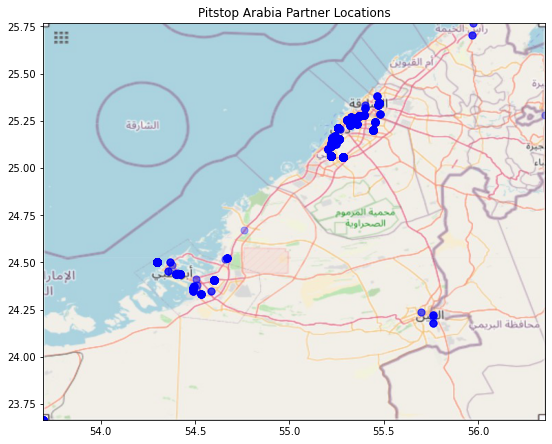

In [41]:
ruh_m = plt.imread('maps/uae_map.jpg')

fig, ax = plt.subplots(figsize = (9,9))
ax.scatter(tyres['Longitude'], tyres['Lattitude'], c='b', s=50, alpha = 0.3)
ax.set_title('Pitstop Arabia Partner Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

I can see from the map that the vast majority of the installations happen in both Dubai and Abu Dhabi, and the rest of the cities don't have enough influence to be considered a major part of the model.

I will split Abu Dhabi and Dubai into chunks, and make the rest of the cities there own chunk. I will then have a few groups, and I can fit a few models to predict the demand in each one. 

In [87]:
dubai = tyres[tyres['Installer City'] == 'Dubai']
abu_dhabi = tyres[tyres['Installer City'] == 'Abu Dhabi']
third_chunk = tyres[(tyres['Installer City'] != 'Abu Dhabi') & (tyres['Installer City'] != 'Dubai')]

dubai = dubai.reset_index().drop('index', axis = 1)
abu_dhabi = abu_dhabi.reset_index().drop('index', axis = 1)
third_chunk = third_chunk.reset_index().drop('index', axis = 1)

In [43]:
#Plotting Dubai first: 
min_lat = dubai['Lattitude'].min()
max_lat = dubai['Lattitude'].max()

min_lng = dubai['Longitude'].min()
max_lng = dubai['Longitude'].max()

BBox = ((min_lng, max_lng,      
         min_lat, max_lat))
print(min_lng, max_lng, min_lat, max_lat)

54.3 55.452685 24.346592 25.281752


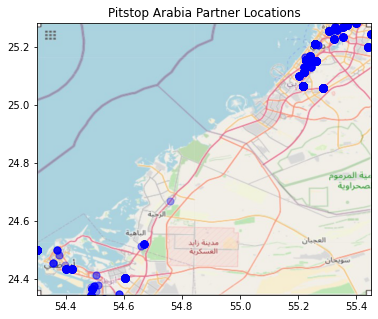

In [45]:
ruh_m = plt.imread('maps/dubai_map.jpg')

fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(tyres['Longitude'], tyres['Lattitude'], c='b', s=50, alpha = 0.3)
ax.set_title('Pitstop Arabia Partner Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

we see 2 very distinct sections of upper dubai and lower dubai. We oculd very easily draw a line in the center (Lattititude = 24.8) and say that everyone whose `latitude > 24.8 = Upper Dubai, else Lower Dubai`

In [88]:
dubai['Section'] = 'dubai'

for i in range(len(dubai['Lattitude'])):
    if dubai.loc[i,'Lattitude'] > 24.8:
        dubai.loc[i,'Section'] = 'Upper Dubai'
    else:
        dubai.loc[i,'Section'] = 'Lower Dubai'

In [104]:
u_dubai = dubai[dubai['Section'] == 'Upper Dubai']
u_dubai.sort_values(by = 'Order Date', inplace = True)
u_dubai = u_dubai.reset_index().drop('index', axis = 1)

l_dubai = dubai[dubai['Section'] == 'Lower Dubai']
l_dubai.sort_values(by = 'Order Date', inplace = True)
l_dubai = l_dubai.reset_index().drop('index', axis = 1)

## Preliminary Model Fitting
We now have our first split city! Let's try and fit a model on top to get an idea as to what needs to happen with other chunks: 

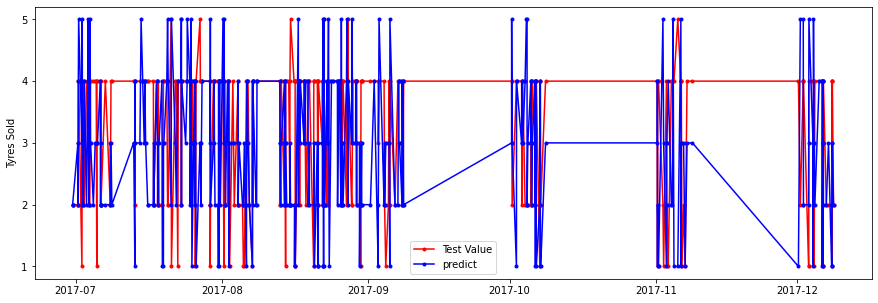

Score: 25.0%


In [121]:
from statsmodels.tsa.ar_model import AR #The model of choice

train_percentage = 0.8
train_size = int(round(len(u_dubai['Order Date']),0) * train_percentage)
train = u_dubai.loc[0:train_size,['QTY Ordered','Order Date']]

test_size = len(u_dubai['Order Date']) - train_size
test = u_dubai.loc[train_size : train_size + test_size,['QTY Ordered','Order Date']]

#Instantiating the model and optimizing it. 
model = AR(train['QTY Ordered'])
model_fit = model.fit(maxlag=600)


#Making the predictions nad making sure they have the appropriate date
predictions = round(model_fit.predict(start=train_size, end=train_size+test_size),0)
predictions = pd.DataFrame(predictions)
predictions.columns = ['QTY Ordered']
predictions['Order Date'] = test['Order Date']


#Ensuring reasonable values are predicted
for j in predictions.index:
    if predictions.loc[j,'QTY Ordered'] > 5 or predictions.loc[j,'QTY Ordered'] < 1: 
        predictions.loc[j,'QTY Ordered'] = 3

#Plotting
plt.figure(figsize = (15,5))
plt.plot(test['Order Date'], test['QTY Ordered'], c="red", label="Test Value", marker='.')
plt.plot(predictions['Order Date'], predictions['QTY Ordered'], c="blue", label="predict", marker='.')
plt.ylabel("Tyres Sold")
plt.yticks(range(1,6,1))
plt.xticks()
plt.legend()
plt.show();


#Scoring
point = 0
for i in range(len(test)):
    if list(test['QTY Ordered'])[i] == list(predictions['QTY Ordered'])[i]:
        point+=1
score = point / len(predictions)
print(f"Score: {round(score*100,2)}%")

Not Terrible! Now let's do the same for the rest of the locations. to speed up the process, I will create a function to do the process automaticaly, thus saving me lots of time. 

While I could use ML piplines, I don't have the full understanding of how to use it yet. It would also be much easier for me to explain the function itself.  

In [160]:
def pitstop_AR(train_pctg, c_val_pctg, df):
    from statsmodels.tsa.ar_model import AR #The model of choice

    train_percentage = train_pctg
    c_val_percentage = c_val_pctg

    train_size = int(round(len(df['Order Date']),0) * train_percentage) #Getting a number from the percentage
    train = df.loc[0:train_size,['QTY Ordered','Order Date']] #Getting the rows with said number

    c_val_size = int(round(len(df['Order Date']),0) * c_val_percentage) #Getting a number from the percentage
    c_val = df.loc[train_size : train_size + c_val_size,['QTY Ordered','Order Date']] #Getting the rows with said number

    test = df.loc[train_size + c_val_size: len(df['Order Date']),['QTY Ordered','Order Date']] #rest of the rows are used for testing
    print(f"{100*round(1-train_pctg - c_val_pctg,2)}% or {len(test['QTY Ordered'])} rows will be used for testing.")

####################################################################################################################

    #Hyper Parameter Optimization
    scores = []
    lag_values = range(2,test_size,5)
    
    for the_lag in lag_values:
        #Instantiating the model and optimizing it. 
        model = AR(df['QTY Ordered'])
        model_fit = model.fit(maxlag=the_lag)


        #Making the predictions nad making sure they have the appropriate date
        predictions = round(model_fit.predict(start=train_size, end=train_size+c_val_size),0)
        predictions = pd.DataFrame(predictions)
        predictions.columns = ['QTY Ordered']
        predictions['Order Date'] = test['Order Date']


        #Ensuring reasonable values are predicted
        for j in predictions.index:
            if predictions.loc[j,'QTY Ordered'] > 5 or predictions.loc[j,'QTY Ordered'] < 1: 
                predictions.loc[j,'QTY Ordered'] = 3


        #Scoring
        point = 0
        for i in range(len(c_val)):
            if list(c_val['QTY Ordered'])[i] == list(predictions['QTY Ordered'])[i]:
                point+=1
        cval_score = point / len(predictions)
        scores.append(cval_score)
    
    #Now that we have the scores, we can take the maximum score and find the lag for it
    
    maximum_score = max(scores)
    
    #getting the index of the max score
    index = 0
    for score in scores:
        if score == maximum_score:
            break
        else:
            index +=1

    ideal_lag = lag_values[index]
    
    
####################################################################################################################
    
    #Plotting
    plt.figure(figsize = (15,5))
    plt.plot(c_val['Order Date'], c_val['QTY Ordered'], c="red", label="Test Value", marker='.')
    plt.plot(predictions['Order Date'], predictions['QTY Ordered'], c="blue", label="predict", marker='.')
    plt.ylabel("Tyres Sold")
    plt.yticks(range(1,6,1))
    plt.xticks()
    plt.legend()
    plt.show();

4